In [1]:
from model_config import ModelConfig
from pruning_methods.wanda import wanda_pruning
from pruning_methods.magnitude import magnitude_pruning
import torch
import matplotlib.pyplot as plt


/home/nicolas/miniconda3/envs/nlpa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from dotenv import load_dotenv
from evaluation_pruning import generate_text


load_dotenv()

token = os.getenv("HUGGINGFACE_TOKEN")

llama_model = "meta-llama/Llama-3.2-1B"
modelConfig = ModelConfig(token=token)
model = modelConfig.load_llm()

Loading model 'facebook/opt-350m' from cache directory '.cache/llm_weights/'...


## Magnitude Pruning

In [3]:
def count_parameters(model):
    """
    Count the total number of non-zero parameters in a model.
    
    Args:
        model (torch.nn.Module): The model to count parameters for
    
    Returns:
        tuple: (total non-zero parameters, trainable non-zero parameters)
    """
    total_nonzero_params = 0
    trainable_nonzero_params = 0
    
    for param in model.parameters():
        num_nonzero_params = torch.count_nonzero(param).item()  # Count non-zero elements
        total_nonzero_params += num_nonzero_params
        if param.requires_grad:
            trainable_nonzero_params += num_nonzero_params
    
    return total_nonzero_params, trainable_nonzero_params


In [4]:
prunedModelConfig = modelConfig.copy_model()

original_model = modelConfig.model
prunned_model = prunedModelConfig.model

pruning_result = magnitude_pruning(prunned_model, 0.5)

print(f"number of parameters in original model: {count_parameters(original_model)}")
print(f"number of parameters in prunned model: {count_parameters(prunned_model)}")

number of parameters in original model: (331195120, 331195120)
number of parameters in prunned model: (166761506, 166761506)


In [5]:
from evaluation_pruning import global_evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prunned_model.to(device)

global_evaluation(prunedModelConfig, device=device)

KeyboardInterrupt: 

In [6]:
from evaluation_pruning import global_evaluation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
original_model.to(device)
prunned_model.to(device)

results = []
ratios = range(1, 90, 10)
for ratio in ratios:
    ratio = ratio / 100
    print(f"Pruning ratio: {ratio}")
    tmpModelConfig = modelConfig.copy_model()
    pruning_result = magnitude_pruning(prunned_model, ratio)
    results.append(global_evaluation(tmpModelConfig, device=device))

Pruning ratio: 0.01


Wikitext Perplexity: 100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Pruning ratio: 0.11


Wikitext Perplexity: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


Pruning ratio: 0.21


Wikitext Perplexity: 100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Pruning ratio: 0.31


Wikitext Perplexity: 100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Pruning ratio: 0.41


Wikitext Perplexity: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


Pruning ratio: 0.51


KeyboardInterrupt: 

[23.599618911743164, 23.599618911743164, 23.599618911743164, 23.599618911743164, 23.599618911743164]


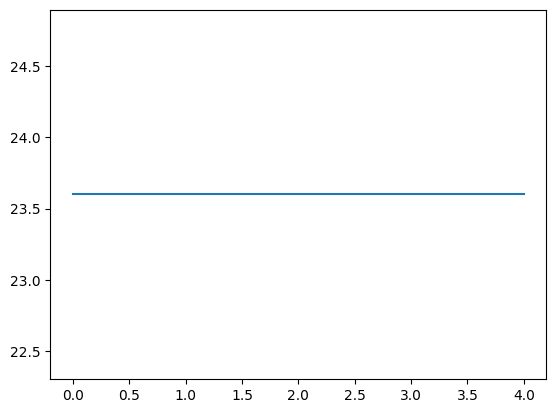

In [9]:
perplexities = [result["perplexity"]["test_ppl"] for result in results]
print(perplexities)
plt.plot(perplexities)

[662538026, 662538026, 662538026, 662538026, 662538026, 662538026, 662538026, 662538026, 662538026]


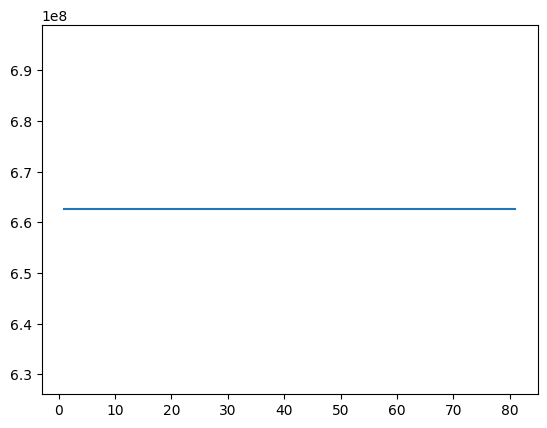

In [ ]:
# Plot memory size over pruning ratio
model_size_bytes = [result["memory"]["model_size_bytes"] for result in results]
print(model_size_bytes)
plt.plot(ratios, [result["memory"]["model_size_bytes"] for result in results])
# print()

## Wanda Pruning

In [ ]:
# wanda_pruning(modelConfig)